In [1]:
import pandas as pd

# open the file
with open("SMSSpamCollection.txt", 'r') as file_object:
    
    # Read the content
    content = file_object.readlines()

# print first 10 records of content list
print(content[:10])

['ham\tGo until jurong point, crazy.. Available only in bugis n great world la e buffet... Cine there got amore wat...\n', 'ham\tOk lar... Joking wif u oni...\n', "spam\tFree entry in 2 a wkly comp to win FA Cup final tkts 21st May 2005. Text FA to 87121 to receive entry question(std txt rate)T&C's apply 08452810075over18's\n", 'ham\tU dun say so early hor... U c already then say...\n', "ham\tNah I don't think he goes to usf, he lives around here though\n", "spam\tFreeMsg Hey there darling it's been 3 week's now and no word back! I'd like some fun you up for it still? Tb ok! XxX std chgs to send, Â£1.50 to rcv\n", 'ham\tEven my brother is not like to speak with me. They treat me like aids patent.\n', "ham\tAs per your request 'Melle Melle (Oru Minnaminunginte Nurungu Vettam)' has been set as your callertune for all Callers. Press *9 to copy your friends Callertune\n", 'spam\tWINNER!! As a valued network customer you have been selected to receivea Â£900 prize reward! To claim call 09061

We can see that the flag and the message are separated by a tab ("\t") and each record is separated from each other by a break ("\n"), so we need to split the records to store them in a pandas dataframe.

In [2]:
# lists to store spam flags and messages after separating them into
spam_flags = []
msgs = []
for row in content:
    row = row.strip("\n,")
    flag, msg = row.split('\t')
    spam_flags.append(flag)
    msgs.append(msg)

print("Number of flags in dataset: ", len(spam_flags))
print("Number of messages in dataset: ", len(msgs))

Number of flags in dataset:  5574
Number of messages in dataset:  5574


Since the amount of spam flags and messages are the same, we can create a dataframe from these 2 lists.

In [3]:
data = {'message': msgs, 'flag': spam_flags}
df = pd.DataFrame(data=data)
df.head()

,message,flag
0,"Go until jurong point, crazy.. Available only ...",ham
1,Ok lar... Joking wif u oni...,ham
2,Free entry in 2 a wkly comp to win FA Cup fina...,spam
3,U dun say so early hor... U c already then say...,ham
4,"Nah I don't think he goes to usf, he lives aro...",ham


We need to remove emoticons and convert emojis (if any) to words.

In [4]:
import re
try:
    import cPickle as pickle
except ImportError:
    import pickle

with open('Emoticon_Dict.p', 'rb') as fp:
    Emoticon_Dict = pickle.load(fp)

def remove_emoticons(text_list):
    for idx, text in enumerate(text_list):
        emoticon_pattern = re.compile(u'(' + u'|'.join(k for k in Emoticon_Dict) + u')')
        text = emoticon_pattern.sub(r'', text)
        text_list[idx] = text
    return text_list

with open('Emoji_Dict.p', 'rb') as fp:
    Emoji_Dict = pickle.load(fp)
Emoji_Dict = {v: k for k, v in Emoji_Dict.items()}

def convert_emojis_to_word(text_list):
    for text in text_list:
        for emot in Emoji_Dict:
            text = re.sub(r'('+emot+')',"_".join(Emoji_Dict[emot].replace(',', '').replace(':','').split()), text)
    return text_list

In [5]:
# perform removal of emoticons and conversion of emojis to words
df['message'] = remove_emoticons(df['message'])
#df['message'] = convert_emojis_to_word(df['message'])

In [6]:
df.sample(10)

,message,flag
3486,Noi got rumour that you going to buy apartment...,ham
1740,U guys never invite me anywhere,ham
1485,"Sorry, I'll call later",ham
2718,Okie.. Thanx..,ham
4087,Lemme know when you're here,ham
2547,Company is very good.environment is terrific a...,ham
859,Spoons it is then okay?,ham
1743,"""EY! CALM DOWNON THEACUSATIONS.. ITXT U COS IW...",ham
5160,I will come with karnan car. Please wait till ...,ham
461,Where did u go? My phone is gonna die you have...,ham


We'll also need to remove special characters, which are non-alphanumeric characters in the message. They often do not bring any values to the spam prediction process.

Having numbers in the messages are not useful either, especially texts usually contain stopword abbrevations like "to" => '2', "for" => 4. Therefore, we are removing numbers too.

In [7]:
# replace some special characters represented using alphabets in HTML
def replace_all(text, dic):
    for i, j in dic.items():
        text = text.replace(i, j)
    return text

# function to remove special characters
def remove_special_chars_numbers(text,dic):
    text = replace_all(text, dic)
    # define the pattern to keep
    pattern = r'[^a-zA-z\s]' 
    text = re.sub(pattern, '', text)
    
    return text
 
# call function
symbols_to_replace = {'&lt;': '', '&gt;': '', '&amp;': 'and'}
for idx, text in enumerate(df['message']):
    df['message'][idx] = remove_special_chars_numbers(text,symbols_to_replace)


In [8]:
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

<AxesSubplot:>

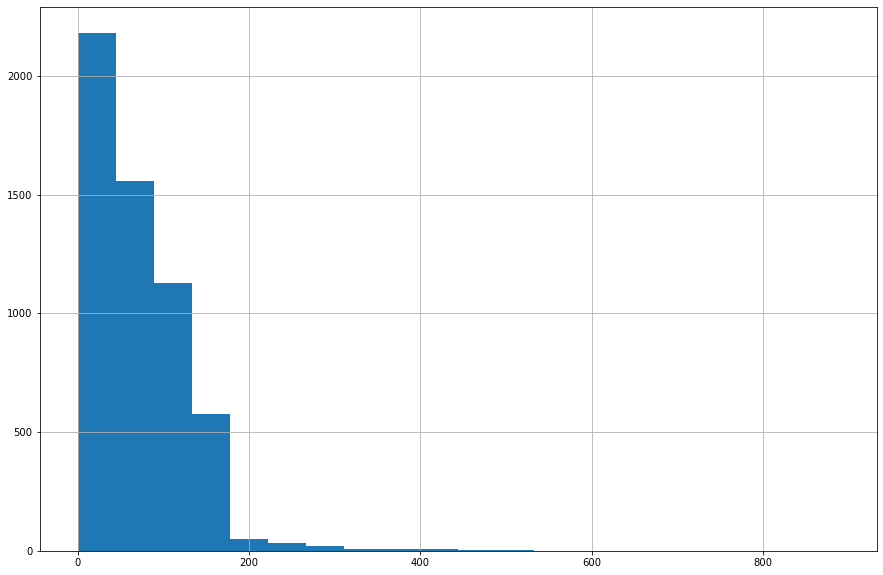

In [9]:
# plot length of message onto a histogram
df['message'].str.len().hist(bins=20, figsize=(15,10))

We can see that most SMS messages consist of fewer than 200 characters.

3376      0
4824      0
1612      0
2322      1
4244      1
       ... 
2434    100
2158    113
2849    113
1863    162
1085    171
Name: message, Length: 5574, dtype: int64


<AxesSubplot:>

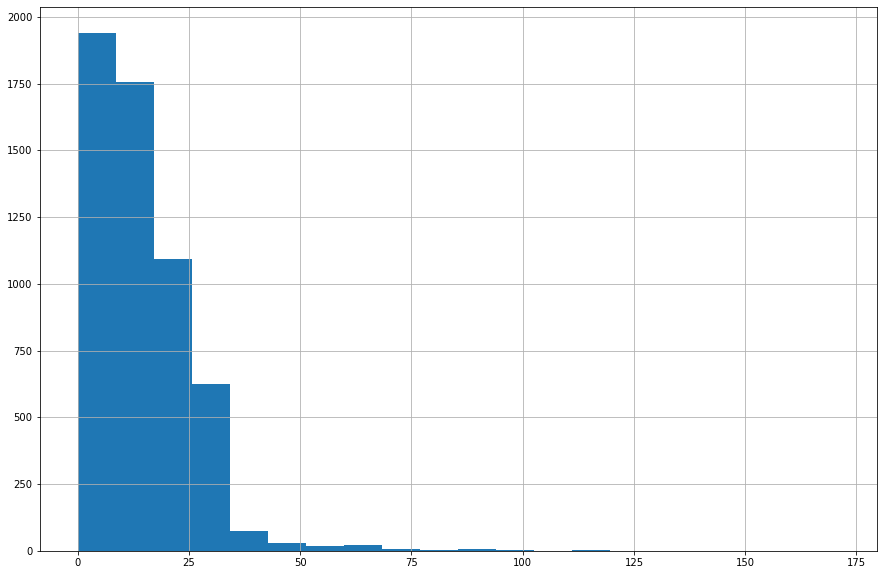

In [10]:
print(df['message'].str.split().map(lambda x: len(x)).sort_values())
df['message'].str.split().map(lambda x: len(x)).hist(bins=20, figsize=(15,10))

Most of the messages have 50 words or fewer, with a few outliers. The longest message has 171 words.

Next, let's check the average word length in each message.

C:\ProgramData\Anaconda3\lib\site-packages\numpy\core\fromnumeric.py:3372: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
C:\ProgramData\Anaconda3\lib\site-packages\numpy\core\_methods.py:170: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


3094    37.000000
4937    16.000000
1009    15.000000
3981    12.000000
2963    12.000000
3862    11.166667
2079    10.500000
4480    10.500000
5468    10.000000
811      9.000000
Name: message, dtype: float64


<AxesSubplot:>

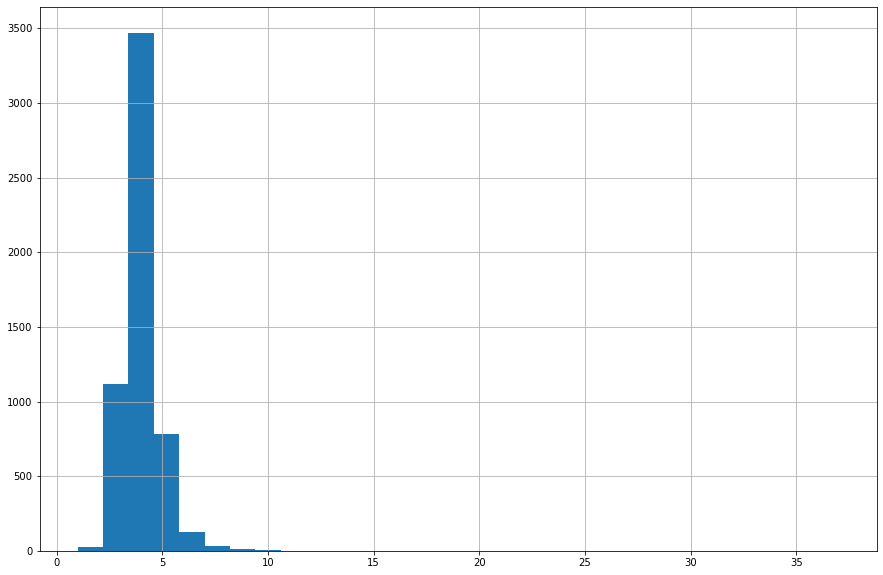

In [11]:
print(df['message'].str.split().apply(lambda x: [len(word) for word in x]). \
    map(lambda x: np.mean(x)).sort_values(ascending=False).head(10))
df['message'].str.split().apply(lambda x: [len(word) for word in x]). \
    map(lambda x: np.mean(x)).hist(bins=30, figsize=(15,10))

There is a message with an average word length of 37! Something must be off here. We'll examine the content of the message.

In [12]:
df.iloc[[3094]]

,message,flag
3094,staffsciencenusedusgphyhcmkteachingpc,ham


So this is a message containing a single URL (special characters and punctuations removed). We can remove it as it doesn't really contain any words.

In [13]:
df.drop([3094], inplace=True)

We'll check the average word length of the messages again.

C:\ProgramData\Anaconda3\lib\site-packages\numpy\core\fromnumeric.py:3372: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
C:\ProgramData\Anaconda3\lib\site-packages\numpy\core\_methods.py:170: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


4937    16.000000
1009    15.000000
3981    12.000000
2963    12.000000
3862    11.166667
4480    10.500000
2079    10.500000
5468    10.000000
811      9.000000
2419     8.909091
Name: message, dtype: float64


<AxesSubplot:>

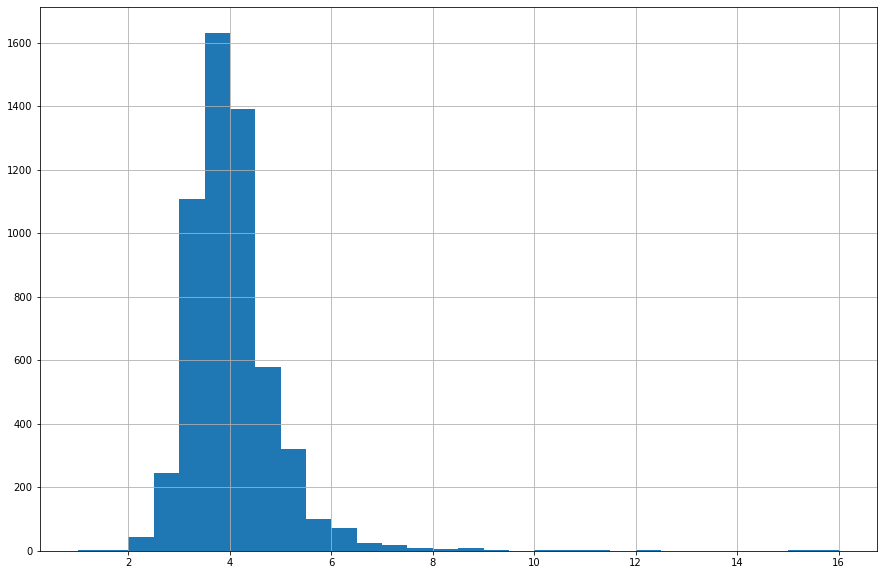

In [14]:
print(df['message'].str.split().apply(lambda x: [len(word) for word in x]). \
    map(lambda x: np.mean(x)).sort_values(ascending=False).head(10))
df['message'].str.split().apply(lambda x: [len(word) for word in x]). \
    map(lambda x: np.mean(x)).hist(bins=30, figsize=(15,10))

Without the outlier, the histogram looks much better, but it is still unusual for a message to have an average word length of 10 or greater.

In [15]:
df.loc[df['message'].str.split().apply(lambda x: [len(word) for word in x]). \
    map(lambda x: np.mean(x)) >= 10]

,message,flag
1009,Poyyarikaturkolathupalayamunjalur posterode dis,ham
2079,FREERingtoneReply REAL,spam
2963,NONENOWHERE IKNO DOESDISCOUNTSHITINNIT,ham
3862,Free Msg RingtoneFrom httptms widelivecomindex...,spam
3981,ringtoneking,spam
4480,Erutupalam thandiyachu,ham
4937,Kkcongratulation,ham
5468,httptms widelivecomindex wmlidadafirsttrueC C ...,spam


These messages are missing spaces after a punctuation or are also URLs. As there are only 14 records, we can also remove them.

In [16]:
df.drop(df.loc[df['message'].str.split().apply(lambda x: [len(word) for word in x]). \
    map(lambda x: np.mean(x)) >= 10].index, inplace=True)

C:\ProgramData\Anaconda3\lib\site-packages\numpy\core\fromnumeric.py:3372: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
C:\ProgramData\Anaconda3\lib\site-packages\numpy\core\_methods.py:170: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


In [17]:
df.shape

(5565, 2)

As we can see from the query above of messages that contains more than 10 words, there are duplicate messages so we'll remove the duplicate records and keep only 1 copy.

In [18]:
df.drop_duplicates(inplace=True)
df.shape

(5112, 2)

More than 400 duplicate records were removed. We'll check to see how many messages belong to each category (spam vs. ham)

In [19]:
spam_count = df[df['flag']=='spam']['message'].count()
ham_count = df[df['flag']=='ham']['message'].count()
total_count = df['message'].count()

print('The number of spam messages is', df[df['flag']=='spam']['message'].count(), \
      'which account for {0:.2f}% of messages'.format(spam_count/total_count*100) )
print('The number of ham messages is', df[df['flag']=='ham']['message'].count(), \
      'which account for {0:.2f}% of messages'.format(ham_count/total_count*100))

The number of spam messages is 614 which account for 12.01% of messages
The number of ham messages is 4498 which account for 87.99% of messages


Messages might contain stopwords, which are words that are most commly used in any language such as "the", "a", "an", etc. These words might have resulted in the above graph being left-skewed, i.e. shorter words appear more frequently.

We'll now analyze these stopwords and their usage frequency in the dataset.

In [20]:
import nltk
from nltk.corpus import stopwords
nltk.download('stopwords')
stop = set(stopwords.words('english'))

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\PC\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


<BarContainer object of 10 artists>

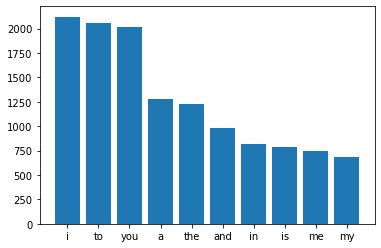

In [21]:
new= df['message'].str.split()
new=new.values.tolist()
corpus=[word for i in new for word in i]

from collections import defaultdict
dic=defaultdict(int)
for word in corpus:
    if word.lower() in stop:
        dic[word.lower()]+=1
top=sorted(dic.items(), key=lambda x:x[1],reverse=True)[:10] 
x,y=zip(*top)
plt.bar(x,y)

So the top 3 stopwords used are 'i', 'to' and 'you'. We'll now remove these words as they carry minimal to no importance.

In [22]:
from nltk.tokenize import ToktokTokenizer

tokenizer = ToktokTokenizer()

#function to remove stopwords
def remove_stopwords(text):
    # convert sentence into token of words
    tokens = tokenizer.tokenize(text)
    tokens = [token.strip() for token in tokens]
    #check in lowercase
    t = [token for token in tokens if token.lower() not in stop]
    text = ' '.join(t)
    return text

# call function
for idx, text in enumerate(df['message']):
    df['message'][idx] = remove_stopwords(text)

Let's inspect which other words are used frequently in each of the category.

<AxesSubplot:>

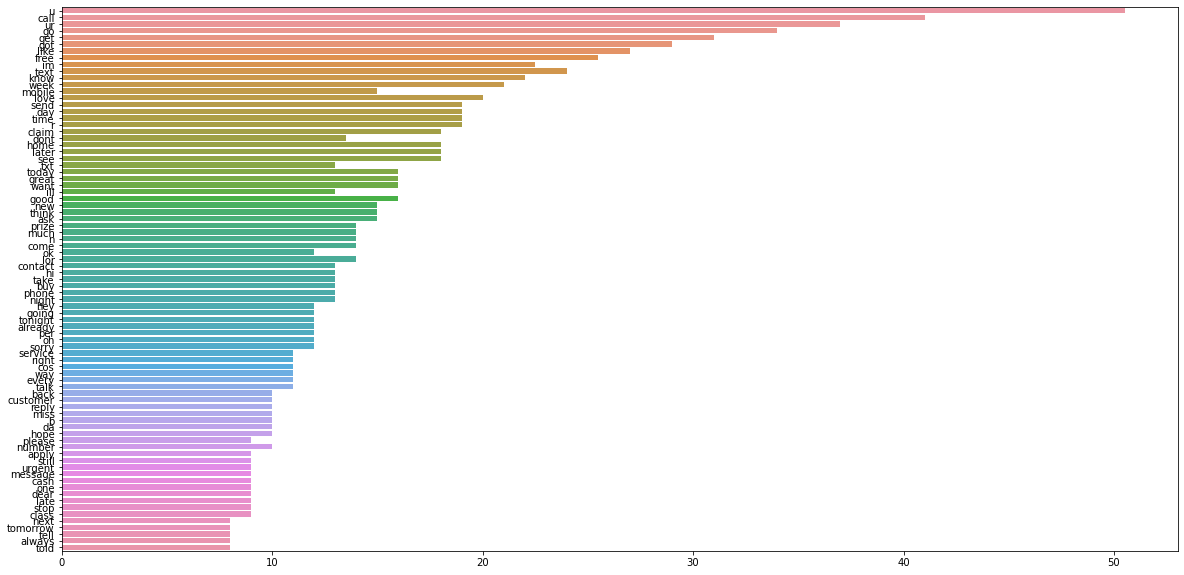

In [23]:
spam_words = df[df['flag']=='spam']['message'].str.split()
spam_words = spam_words.values.tolist()
spam_corpus = [word for i in spam_words for word in i]

from collections import Counter
spam_counter = Counter(spam_corpus)
spam_most = spam_counter.most_common()

x, y = [], []
for word,count in spam_most[:100]:
    if (word.lower() not in stop):
        x.append(count)
        y.append(word.lower())

plt.figure(figsize=(20,10))        
sns.barplot(x=x,y=y, ci=None)

<AxesSubplot:>

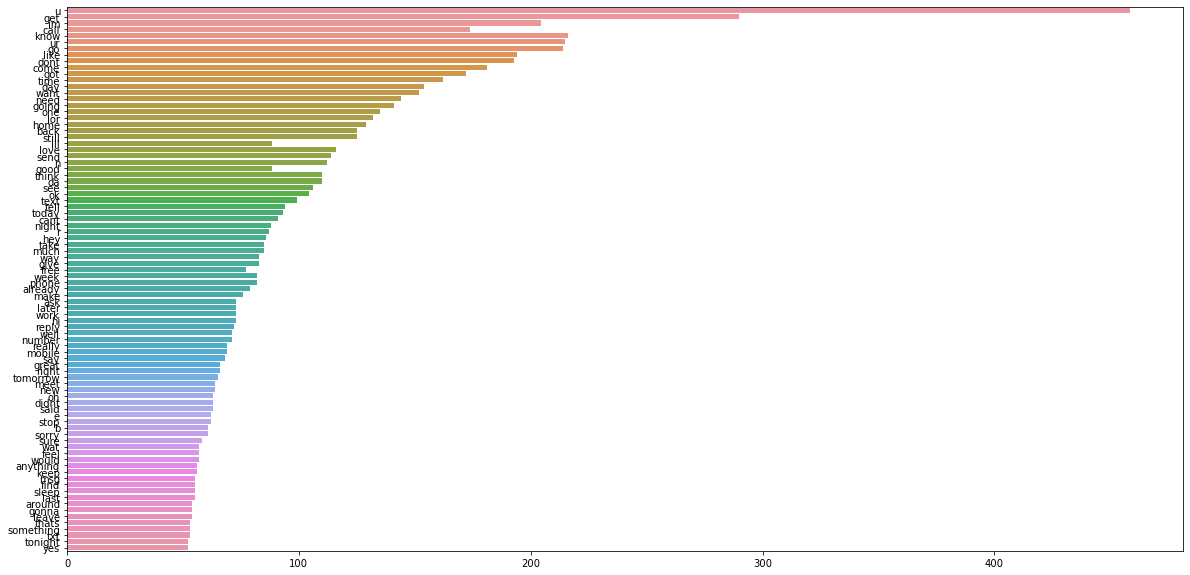

In [24]:
ham_words = df[df['flag']=='ham']['message'].str.split()
ham_words = ham_words.values.tolist()
ham_corpus = [word for i in ham_words for word in i]

from collections import Counter
ham_counter = Counter(ham_corpus)
ham_most = ham_counter.most_common()

x, y = [], []
for word,count in ham_most[:100]:
    if (word.lower() not in stop):
        x.append(count)
        y.append(word.lower())

plt.figure(figsize=(20,10))        
sns.barplot(x=x,y=y, ci=None)

# Ngram exploration

Here we look at combination of words that go together most frequently, in pairs or in groups of three.

In [25]:
from nltk.util import ngrams
from sklearn.feature_extraction.text import CountVectorizer

<AxesSubplot:>

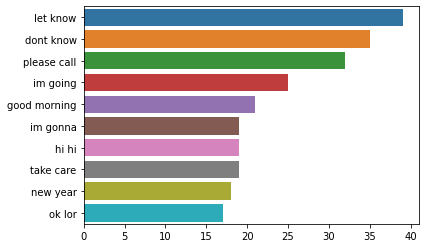

In [26]:
def get_top_ngram(corpus, n=None):
    vec = CountVectorizer(ngram_range=(n, n)).fit(corpus)
    bag_of_words = vec.transform(corpus)
    sum_words = bag_of_words.sum(axis=0) 
    words_freq = [(word, sum_words[0, idx]) 
                  for word, idx in vec.vocabulary_.items()]
    words_freq =sorted(words_freq, key = lambda x: x[1], reverse=True)
    return words_freq[:10]

# Top bigrams of ham messages
ham_top_n_bigrams = get_top_ngram(df[df['flag']=='ham']['message'],2)[:10] 
x,y=map(list,zip(*ham_top_n_bigrams)) 
sns.barplot(x=y,y=x)

<AxesSubplot:>

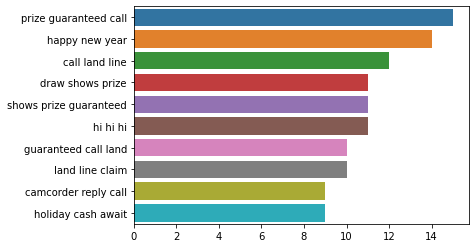

In [27]:
# Top trigrams of ham messages
ham_top_n_trigrams = get_top_ngram(df[df['flag']=='ham']['message'],3)[:10] 
x,y=map(list,zip(*ham_top_n_trigrams)) 
sns.barplot(x=y,y=x)

<AxesSubplot:>

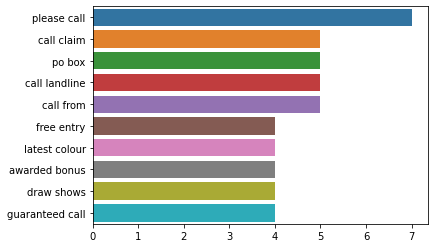

In [28]:
# Top bigrams of spam messages
spam_top_n_bigrams = get_top_ngram(df[df['flag']=='spam']['message'],2)[:10] 
x,y=map(list,zip(*spam_top_n_bigrams)) 
sns.barplot(x=y,y=x)

<AxesSubplot:>

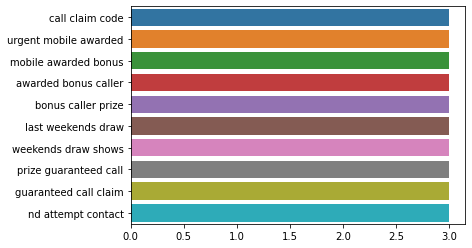

In [29]:
# Top trigrams of spam messages
spam_top_n_trigrams = get_top_ngram(df[df['flag']=='spam']['message'],3)[:10] 
x,y=map(list,zip(*spam_top_n_trigrams)) 
sns.barplot(x=y,y=x)

One thing we can notice is that for spam messages, the top trigrams are some word combinations indicating the recipient has either won something or missed an important call. These usually are used to urge the recipient to take an action/call a certain number, and are likely to have scams involved.

# Wordcloud

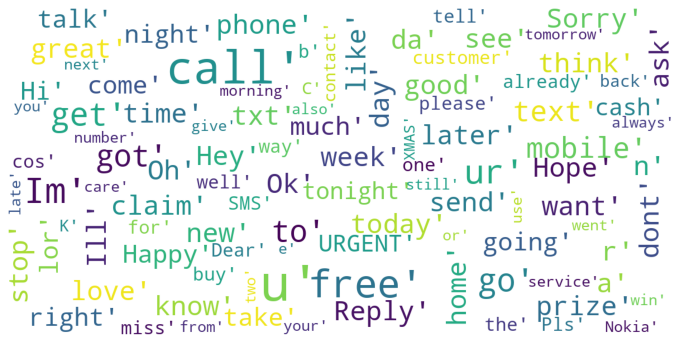

In [30]:
from wordcloud import WordCloud, STOPWORDS
stopwords = set(STOPWORDS)

def show_wordcloud(data):
    wordcloud = WordCloud(
        background_color='white',
        stopwords=stopwords,
        max_words=100,
        max_font_size=30,
        scale=3,
        random_state=1)
   
    wordcloud=wordcloud.generate(str(data))

    fig = plt.figure(1, figsize=(12, 12))
    plt.axis('off')

    plt.imshow(wordcloud)
    plt.show()

show_wordcloud(spam_corpus)

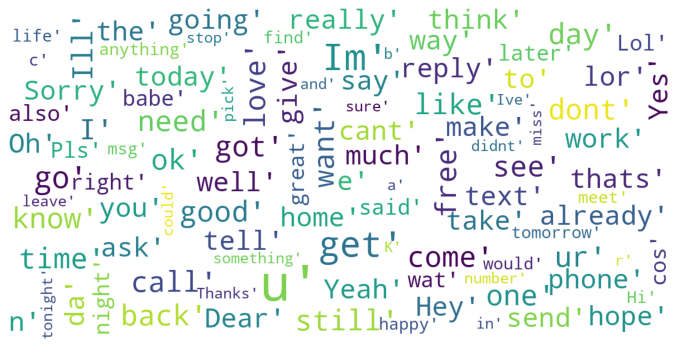

In [31]:
show_wordcloud(ham_corpus)

We can see that spam messages usually mention something "Free" or related to money ("cash", "win" or a number most likely to represent an amount of money), and call-to-action words like "call", "text", "txt".

On the other hand, ham messages do not have clear patterns.

# Named entity recognition

Named entity recognition is an information extraction method in which entities that are present in the text are classified into predefined entity types like “Person”,” Place”,” Organization”, etc. We will use the library spaCy to extract this data.

In [32]:
import spacy

# use pre-trained model en_core_web_md with spaCy
nlp = spacy.load("en_core_web_md")

First, we will define a function to run the named entity recognition on our messages and store the entity types.

In [33]:
def ner(text):
    doc = nlp(text)
    return [X.label_ for X in doc.ents]

<AxesSubplot:>

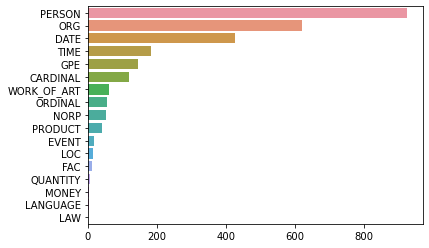

In [34]:
# non-spam messages NER
ham_ent = df[df['flag']=='ham']['message'].apply(lambda x: ner(x))
ham_ent = [x for sub in ham_ent for x in sub]

counter = Counter(ham_ent)
count = counter.most_common()

# visualize the entity frequencies:
x,y=map(list,zip(*count))
sns.barplot(x=y,y=x)

<AxesSubplot:>

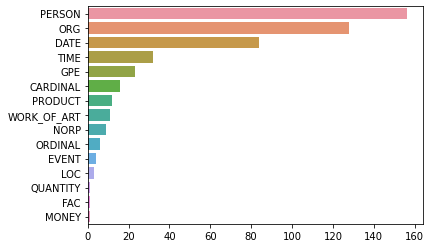

In [35]:
# spam messages NER
spam_ent = df[df['flag']=='spam']['message'].apply(lambda x: ner(x))
spam_ent = [x for sub in spam_ent for x in sub]

counter = Counter(spam_ent)
count = counter.most_common()

# visualize the entity frequencies:
x,y=map(list,zip(*count))
sns.barplot(x=y,y=x)

We can see that people names have the highest frequency in non-spam messages. This is expected as the messages are similar to real-life conversations between people.

Organization names, people names and dates are in the top 3 of most commonly used named entity types for both spam and non-spam SMSes. 

# Stemming

Stemming is the process of reducing inflected/derived words to their word stem, base or root form. The stem need not be identical to original word. There are many ways to perform stemming such as lookup table, suffix-stripping algorithms etc. These mainly rely on chopping-off ‘s’, ‘es’, ‘ed’, ‘ing’, ‘ly’ etc from the end of the words and sometimes the conversion is not desirable. But nonetheless, stemming helps us in standardizing text.

In [39]:
# function for stemming
def get_stem(text):
    stemmer = nltk.porter.PorterStemmer()
    text = ' '.join([stemmer.stem(word) for word in text.split()])
    return text

# call function
for idx, text in enumerate(df['message']):
    df['message'][idx] = get_stem(text)

In [40]:
from library.sb_utils import save_file

# save the data to a new csv file
datapath = 'data'
save_file(df, 'SMSSpamCollection_cleaned.csv', datapath)

A file already exists with this name.

Do you want to overwrite? (Y/N)y
Writing file.  "data\SMSSpamCollection_cleaned.csv"
